# Emoji Prediction - ECS 171 Group Project

### Project Overview

Emojis are widely used for modern communication, and offer a way to express emotions visually. Through computer vision and machine learning, the aim of our project is to be able to predict the emoji that best fits a given facial expression. Since there are many available emojis representing different emotions, to keep our project simple and achievable within the given time constraint, we are going to use just a few: Happy, Sad, and Neutral. If time permits, we will move onto more complex emotions: Angry, Disgust, Fear, and Surprise. Our approach is to use a Convolution Neural Network for facial recognition, and we are going to classify these expressions into a category of emotions. From there, we will simply output the emoji that matches that particular emotion. 

### Description of Dataset

The dataset we are using can be found here. 

There are 4,254 observations in the dataset, with 1774 happy observations, 1233 neutral observations, and 1247 sad observations. Each “observation”, or image file, is a 48x48 pixel sized grayscale image of expressions on faces. Sizes are all standardized to 


### Data Exploration

First, we must explore the data.

i.e. evaluate your data, # of observations, details about your data distributions, scales, missing data, column descriptions) Note: For image data you can still describe your data by the number of classes, # of images, size of images, are sizes standardized? do they need to be cropped? normalized? Etc.


In [ ]:
# importing libraries
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import load_img

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import MaxPool2D, Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
import keras.utils as image
from keras import regularizers


In [ ]:
! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d msambare/fer2013

In [ ]:
! unzip fer2013.zip;

# Data Evaluation

Goes through the dataset and describes data by defining number of classes, # of images, and size of images. 


In [ ]:
IMAGE_SIZE = 48
BATCH_SIZE = 64

In [ ]:
train_dir = './train/'
test_dir = './test/'
# # image size
# row, col = IMAGE_SIZE, IMAGE_SIZE
# # number of image classes: angry, sad, etc
# classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df

# number of observations
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       happy  fear  angry   sad  neutral  disgust  surprise
train   7215  4097   3995  4830     4965      436      3171
      happy  fear  angry   sad  neutral  disgust  surprise
test   1774  1024    958  1247     1233      111       831


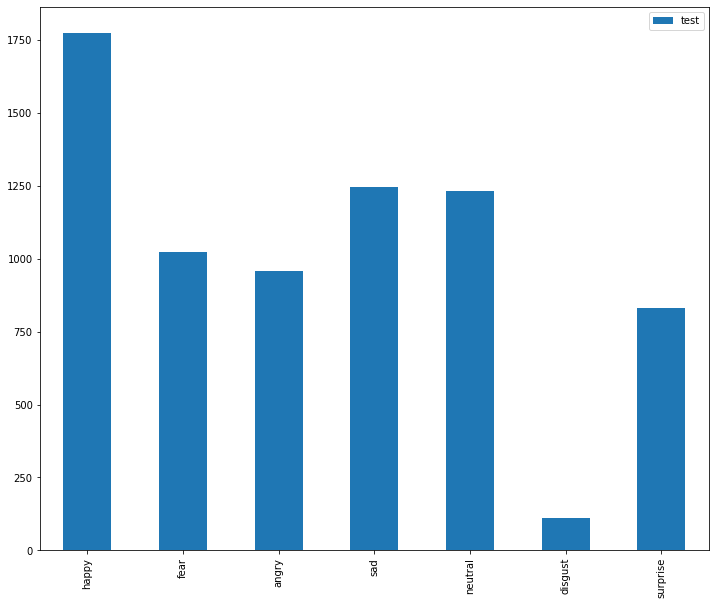

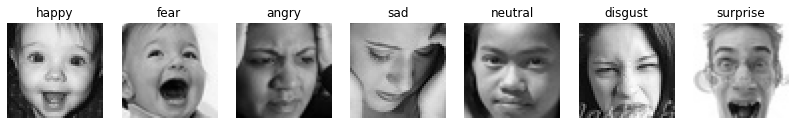

In [ ]:
test_count.transpose().plot(kind='bar',figsize=(12, 10))

plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

# Data Preprocessing



In [ ]:
shutil.rmtree( './train/disgust')
shutil.rmtree( './test/disgust')


In [ ]:
# train dataset
images = []
labels = []
for subset in os.listdir(train_dir):
  image_list = os.listdir(os.path.join(train_dir,subset))  # all the names of images in the directory
  image_list = list(map(lambda x:os.path.join(subset,x),image_list))
  images.extend(image_list)
  labels.extend([subset]*len(image_list)) 

df = pd.DataFrame({"Images":images,"Labels":labels})      
df = df.sample(frac=1).reset_index(drop=True) # this will shuffle the data
samplesize = int(int(df.size)/14)  # sample size used for modelling 
print(samplesize)
df_train = df.head(samplesize)  

4039


In [ ]:
# test dataset
images = []
labels = []
for subset in os.listdir(test_dir):
  image_list = os.listdir(os.path.join(test_dir,subset))  # all the names of images in the directory
  image_list = list(map(lambda x:os.path.join(subset,x),image_list))
  images.extend(image_list)
  labels.extend([subset]*len(image_list)) 

df = pd.DataFrame({"Images":images,"Labels":labels})      
df = df.sample(frac=1).reset_index(drop=True) # To shuffle the data 
samplesize = int(int(df.size)/14)  # sample size used for modelling
print(samplesize)
df_test = df.head(samplesize) 

1009


In [ ]:
datagen=ImageDataGenerator(rescale=1./255.,
                        validation_split=0.2,
                        )
train_generator = datagen.flow_from_dataframe(
    directory = train_dir, 
    dataframe=df_train,
    x_col="Images",
    y_col="Labels",
    subset="training",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    target_size=(IMAGE_SIZE,IMAGE_SIZE), 
    class_mode="categorical", 
    color_mode="grayscale"
)

valid_generator=datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=train_dir,
    x_col="Images",
    y_col="Labels",
    subset="validation",
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(IMAGE_SIZE,IMAGE_SIZE)
)

test_datagen=ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    directory = test_dir, 
    target_size=(IMAGE_SIZE,IMAGE_SIZE), 
    #class_mode="categorical", 
    class_mode=None,
    shuffle=False,
    color_mode="grayscale",
    dataframe = df_test,
    x_col="Images",
    y_col="Labels",
    batch_size=BATCH_SIZE,
    seed=42,
)

Found 3232 validated image filenames belonging to 6 classes.
Found 807 validated image filenames belonging to 6 classes.
Found 1009 validated image filenames.


In [ ]:
def plotValidationLossAccuracy(model):
    figure, axis = plt.subplots(1,2)
    figure.set_size_inches(16,6)

    train_ACC = model.history['accuracy']
    train_loss = model.history['loss']

    axis[0].plot(model.history['accuracy'], color = "green")
    axis[0].plot(model.history['val_accuracy'])
    axis[0].set_xlabel('Number of Epochs')
    axis[0].set_ylabel('Accuracy values')
    axis[0].set_title('Training against Validation Accuracy')
    axis[0].legend(['Train', 'Test'], loc = 'lower left')

    axis[1].plot(model.history['loss'], color = "green")
    axis[1].plot(model.history['val_loss'])
    axis[1].set_title('Training against Validation Loss')
    axis[1].set_xlabel('Number of Epochs')
    axis[1].set_ylabel('Loss Values')
    axis[1].set_title('Training against Validation Loss')
    axis[1].legend(['Train', 'Test'], loc ='lower left')

    plt.show()

In [ ]:
def getAccuracy(model):
    test_generator.reset()
    pred=model.predict(test_generator, steps=STEP_SIZE_TEST)

    train_loss, train_ACC = model.evaluate(train_generator)
    test_loss, test_ACC   = model.evaluate(valid_generator)
    print("The train accuracy = {:.3f} , test accuracy = {:.3f}".format(train_ACC*100, test_ACC*100))

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

# Model 1

In [ ]:
model= tf.keras.models.Sequential()
# basic CNN

model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE,1)))
model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))

model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))

model.add(Flatten())

model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='sigmoid'))
model.add(Dense(6, activation='softmax'))

model.compile(
    optimizer = Adam(), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

In [ ]:
firstModel = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=40
)

Epoch 1/40


<ipython-input-38-6768067e7344>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  firstModel = model.fit_generator(generator=train_generator,


50/50 [==============================] - 11s 214ms/step - loss: 1.7693 - accuracy: 0.2408 - val_loss: 1.7674 - val_accuracy: 0.2318
Epoch 2/40
50/50 [==============================] - 10s 208ms/step - loss: 1.7432 - accuracy: 0.2551 - val_loss: 1.7319 - val_accuracy: 0.2578
Epoch 3/40
50/50 [==============================] - 10s 210ms/step - loss: 1.7083 - accuracy: 0.2730 - val_loss: 1.6973 - val_accuracy: 0.2839
Epoch 4/40
50/50 [==============================] - 12s 238ms/step - loss: 1.6757 - accuracy: 0.2948 - val_loss: 1.6756 - val_accuracy: 0.3099
Epoch 5/40
50/50 [==============================] - 16s 328ms/step - loss: 1.6263 - accuracy: 0.3245 - val_loss: 1.6369 - val_accuracy: 0.3307
Epoch 6/40
50/50 [==============================] - 12s 247ms/step - loss: 1.5731 - accuracy: 0.3611 - val_loss: 1.5989 - val_accuracy: 0.3737
Epoch 7/40
50/50 [==============================] - 11s 214ms/step - loss: 1.5275 - accuracy: 0.4037 - val_loss: 1.5944 - val_accuracy: 0.3737
Epoch 8/40

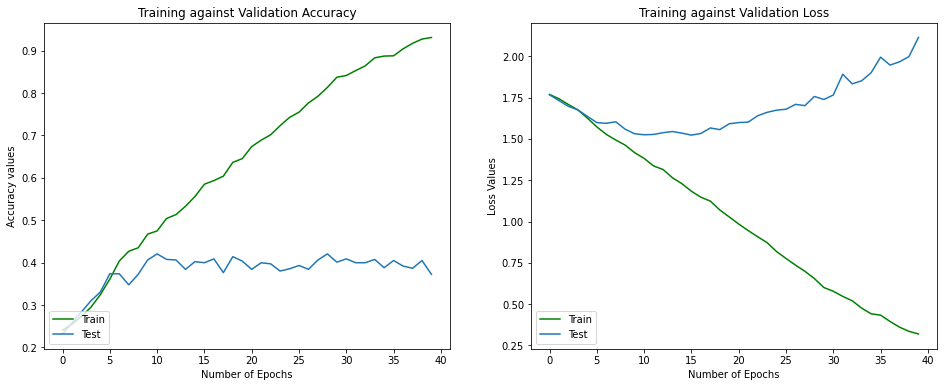

In [ ]:
plotValidationLossAccuracy(firstModel)

In [ ]:
getAccuracy(model)

13/13 [==============================] - 1s 61ms/step - loss: 2.1134 - accuracy: 0.3742
The train accuracy = 92.450 , test accuracy = 37.423


# Model 2

In [ ]:
model2 = tf.keras.models.Sequential()
# add more layers 

model2.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE,1)))
model2.add(MaxPooling2D(pool_size=(2, 2), padding="same"))

model2.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2), padding="same"))

model2.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2), padding="same"))

model2.add(Flatten())

model2.add(Dense(128, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(16, activation='sigmoid'))
model2.add(Dense(6, activation='softmax'))

model2.compile(
    optimizer = Adam(), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

In [ ]:
secondModel = model2.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=40
)

Epoch 1/40


<ipython-input-42-30b91767dc3e>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  secondModel = model2.fit_generator(generator=train_generator,


50/50 [==============================] - 54s 1s/step - loss: 1.7691 - accuracy: 0.2487 - val_loss: 1.7668 - val_accuracy: 0.2370
Epoch 2/40
50/50 [==============================] - 39s 789ms/step - loss: 1.7625 - accuracy: 0.2484 - val_loss: 1.7628 - val_accuracy: 0.2357
Epoch 3/40
50/50 [==============================] - 40s 794ms/step - loss: 1.7574 - accuracy: 0.2459 - val_loss: 1.7567 - val_accuracy: 0.2370
Epoch 4/40
50/50 [==============================] - 40s 802ms/step - loss: 1.7318 - accuracy: 0.2500 - val_loss: 1.7338 - val_accuracy: 0.2487
Epoch 5/40
50/50 [==============================] - 42s 834ms/step - loss: 1.6809 - accuracy: 0.2967 - val_loss: 1.6766 - val_accuracy: 0.2865
Epoch 6/40
50/50 [==============================] - 40s 797ms/step - loss: 1.6191 - accuracy: 0.3251 - val_loss: 1.6499 - val_accuracy: 0.3307
Epoch 7/40
50/50 [==============================] - 40s 805ms/step - loss: 1.5729 - accuracy: 0.3652 - val_loss: 1.5934 - val_accuracy: 0.3464
Epoch 8/40
50

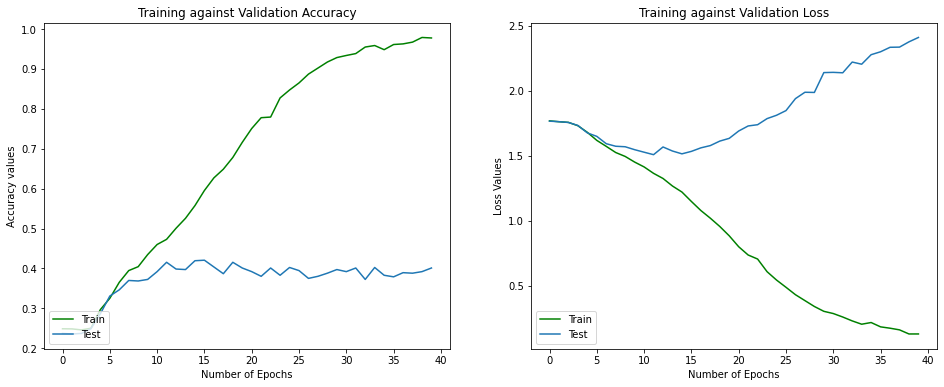

In [ ]:
plotValidationLossAccuracy(secondModel)

In [ ]:
getAccuracy(model2)

13/13 [==============================] - 2s 184ms/step - loss: 2.4048 - accuracy: 0.4002
The train accuracy = 98.360 , test accuracy = 40.025


# Model 3

In [ ]:
model3 = tf.keras.models.Sequential()
# add some layers to prevent overfitting

model3.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE,1)))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
model3.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
model3.add(Dropout(0.2))

model3.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
model3.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
model3.add(Dropout(0.2))

model3.add(Flatten())

model3.add(Dropout(0.25))
model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.25))
model3.add(Dense(32, activation='sigmoid'))
model3.add(Dense(6, activation='softmax'))

model3.compile(
    optimizer = Adam(), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

In [ ]:
thirdModel = model3.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=40
)

<ipython-input-48-12cc247feb46>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  thirdModel = model3.fit_generator(generator=train_generator,


Epoch 1/40
50/50 [==============================] - 20s 367ms/step - loss: 1.8422 - accuracy: 0.2080 - val_loss: 2.0959 - val_accuracy: 0.1367
Epoch 2/40
50/50 [==============================] - 19s 387ms/step - loss: 1.7271 - accuracy: 0.2620 - val_loss: 1.9606 - val_accuracy: 0.1315
Epoch 3/40
50/50 [==============================] - 18s 367ms/step - loss: 1.6999 - accuracy: 0.2898 - val_loss: 1.8430 - val_accuracy: 0.2422
Epoch 4/40
50/50 [==============================] - 18s 362ms/step - loss: 1.6358 - accuracy: 0.3371 - val_loss: 1.7894 - val_accuracy: 0.2396
Epoch 5/40
50/50 [==============================] - 18s 360ms/step - loss: 1.5830 - accuracy: 0.3554 - val_loss: 1.8483 - val_accuracy: 0.2422
Epoch 6/40
50/50 [==============================] - 18s 361ms/step - loss: 1.5251 - accuracy: 0.3864 - val_loss: 1.7957 - val_accuracy: 0.3086
Epoch 7/40
50/50 [==============================] - 18s 359ms/step - loss: 1.4847 - accuracy: 0.4097 - val_loss: 1.7944 - val_accuracy: 0.3138

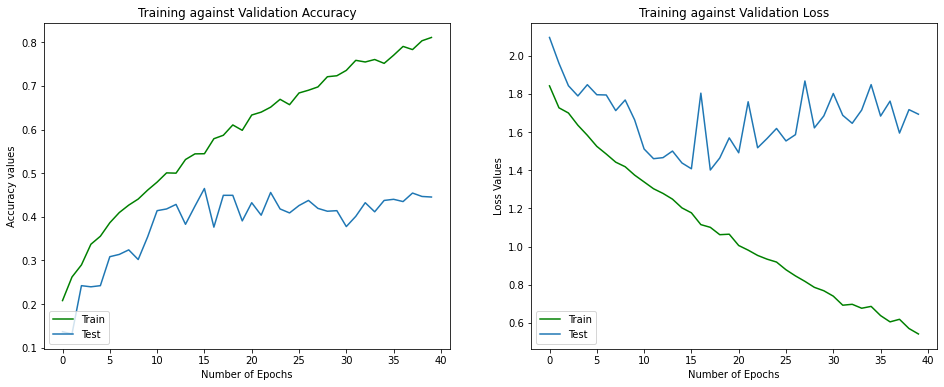

In [ ]:
plotValidationLossAccuracy(thirdModel)

In [ ]:
getAccuracy(model3)

13/13 [==============================] - 1s 91ms/step - loss: 1.7017 - accuracy: 0.4436
The train accuracy = 89.666 , test accuracy = 44.362


# Model 4

In [ ]:
model4 = tf.keras.models.Sequential()
# add some more layers to prevent overfitting

model4.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE,1)))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
model4.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
model4.add(Dropout(0.2))

model4.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
model4.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
model4.add(Dropout(0.2))

model4.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
model4.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
model4.add(Dropout(0.2))

model4.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
model4.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
model4.add(Dropout(0.2))

model4.add(Flatten())

model4.add(Dropout(0.25))
model4.add(Dense(64, activation='relu'))
model4.add(Dropout(0.25))
model4.add(Dense(32, activation='sigmoid'))
model4.add(Dense(6, activation='softmax'))

model4.compile(
    optimizer = Adam(), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

In [ ]:
fourthModel = model4.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=40
)

Epoch 1/40


<ipython-input-52-030d04f02de8>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fourthModel = model4.fit_generator(generator=train_generator,


50/50 [==============================] - 29s 540ms/step - loss: 1.7941 - accuracy: 0.2074 - val_loss: 1.7826 - val_accuracy: 0.1484
Epoch 2/40
50/50 [==============================] - 28s 560ms/step - loss: 1.7251 - accuracy: 0.2544 - val_loss: 1.7705 - val_accuracy: 0.2409
Epoch 3/40
50/50 [==============================] - 27s 537ms/step - loss: 1.6794 - accuracy: 0.2917 - val_loss: 1.7836 - val_accuracy: 0.2383
Epoch 4/40
50/50 [==============================] - 26s 515ms/step - loss: 1.6231 - accuracy: 0.3286 - val_loss: 1.8789 - val_accuracy: 0.2422
Epoch 5/40
50/50 [==============================] - 26s 513ms/step - loss: 1.5851 - accuracy: 0.3567 - val_loss: 2.0008 - val_accuracy: 0.2409
Epoch 6/40
50/50 [==============================] - 26s 513ms/step - loss: 1.5220 - accuracy: 0.4028 - val_loss: 1.9926 - val_accuracy: 0.2357
Epoch 7/40
50/50 [==============================] - 25s 510ms/step - loss: 1.4774 - accuracy: 0.4085 - val_loss: 1.9828 - val_accuracy: 0.2617
Epoch 8/40

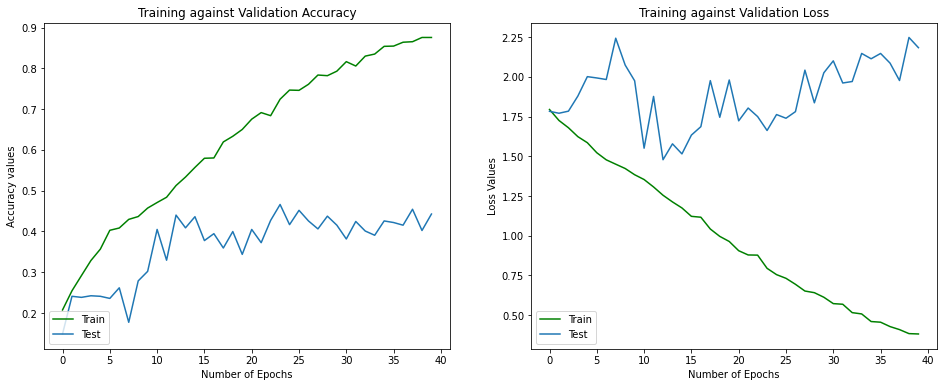

In [ ]:
plotValidationLossAccuracy(fourthModel)

In [ ]:
getAccuracy(model4)

13/13 [==============================] - 1s 95ms/step - loss: 2.1715 - accuracy: 0.4436
The train accuracy = 94.957 , test accuracy = 44.362


# Model 5

In [ ]:
model5 = tf.keras.models.Sequential()
# add regularizations to optimize loss function and improve accuracy 

model5.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE,1)))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
model5.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
model5.add(Dropout(0.2))

model5.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
model5.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
model5.add(Dropout(0.2))

model5.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
model5.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
model5.add(Dropout(0.2))

model5.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
model5.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
model5.add(Dropout(0.2))

model5.add(Flatten())

model5.add(Dropout(0.25))
model5.add(Dense(64, activation='relu'))
model5.add(Dropout(0.25))
model5.add(Dense(32, activation='sigmoid'))
model5.add(Dense(6, activation='softmax'))

model5.compile(
    optimizer = Adam(lr=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
fifthModel = model5.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=40
)

<ipython-input-76-08a06ea870ec>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fifthModel = model5.fit_generator(generator=train_generator,


Epoch 1/40
50/50 [==============================] - 31s 597ms/step - loss: 3.9117 - accuracy: 0.3592 - val_loss: 3.9587 - val_accuracy: 0.3138
Epoch 2/40
50/50 [==============================] - 26s 519ms/step - loss: 3.8444 - accuracy: 0.3580 - val_loss: 3.8884 - val_accuracy: 0.3307
Epoch 3/40
50/50 [==============================] - 26s 519ms/step - loss: 3.7737 - accuracy: 0.3775 - val_loss: 3.8247 - val_accuracy: 0.3477
Epoch 4/40
50/50 [==============================] - 28s 560ms/step - loss: 3.7141 - accuracy: 0.3759 - val_loss: 3.7503 - val_accuracy: 0.3542
Epoch 5/40
50/50 [==============================] - 27s 542ms/step - loss: 3.6519 - accuracy: 0.3996 - val_loss: 3.7708 - val_accuracy: 0.3281
Epoch 6/40
50/50 [==============================] - 26s 516ms/step - loss: 3.5796 - accuracy: 0.4081 - val_loss: 3.6645 - val_accuracy: 0.3581
Epoch 7/40
50/50 [==============================] - 26s 519ms/step - loss: 3.5415 - accuracy: 0.4003 - val_loss: 3.5838 - val_accuracy: 0.3802

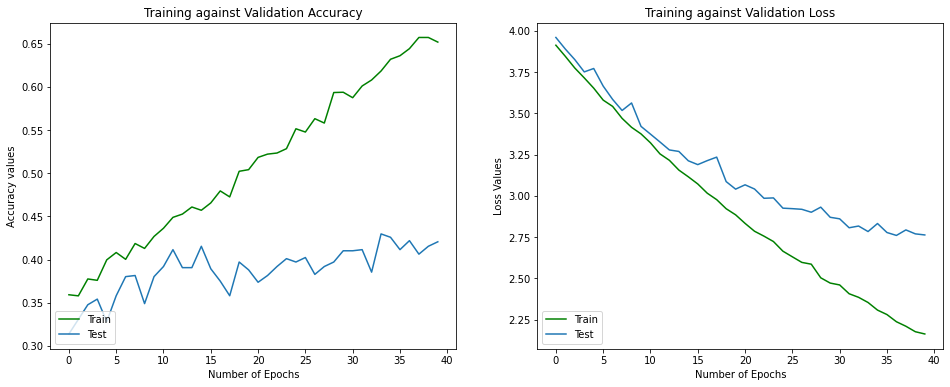

In [ ]:
plotValidationLossAccuracy(fifthModel)

In [ ]:
getAccuracy(model5)

13/13 [==============================] - 1s 97ms/step - loss: 2.7470 - accuracy: 0.4238
The train accuracy = 84.963 , test accuracy = 42.379


# Test on Image

Applying the model on a random image to test it.

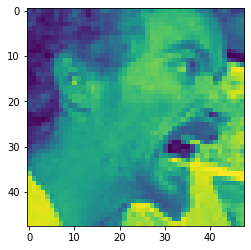

In [ ]:
img = image.load_img("./test/angry/PrivateTest_10304478.jpg", target_size = (48,48), color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)

In [ ]:
label_dict = {0:'Angry',1:'Fear',2:'Happy',3:'Neutral',4:'Sad',5:'Surprise'}


In [ ]:
img = np.expand_dims(img,axis = 0) #makes image shape (1,48,48)
img = img.reshape(1,48,48,1)
result = model4.predict(img)
result = list(result[0])
print(result)

1/1 [==============================] - 0s 223ms/step
[0.38421318, 0.2828692, 0.10745788, 0.010863275, 0.19881843, 0.015777988]


In [ ]:
img_index = result.index(max(result))
print(label_dict[img_index])
plt.show()

Angry
